In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Neural Process for 1D functions

This notebook shows how to train and sample from a Neural Process for a simple class of 1D functions. The functions are defined by f(x) = a * sin(x - b) where a and b and randomly sampled.

### Visualize Data

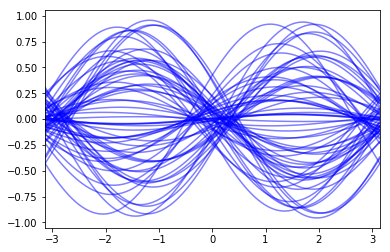

In [2]:
from datasets import SineData
from math import pi

# Create dataset
dataset = SineData(amplitude_range=(-1., 1.),
                   shift_range=(-.5, .5),
                   num_samples=2000)

# Visualize data samples
for i in range(64):
    x, y = dataset[i] 
    plt.plot(x.numpy(), y.numpy(), c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Build Neural Process

In [3]:
from neural_process import NeuralProcess

x_dim = 1
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder

neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

### Visualize samples from prior

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

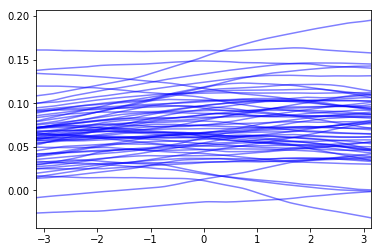

In [4]:
# Create a set of 100 target points, with shape 
# (batch_size, num_points, x_dim), which in this case is
# (1, 100, 1)
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))  # Shape (batch_size, z_dim)
    # Map x_target and z to p_y_target (which is parameterized by a 
    # normal with mean mu and std dev sigma)
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Train Neural Process

iteration 200, loss 3.751
iteration 400, loss 3.907
iteration 600, loss 0.716
iteration 800, loss 1.549
iteration 1000, loss 4.837
Epoch: 0, Avg_loss: 4.129920265569817


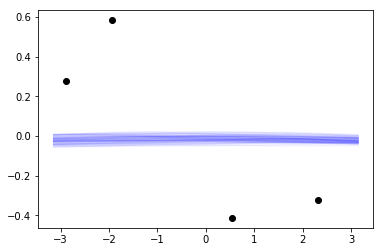

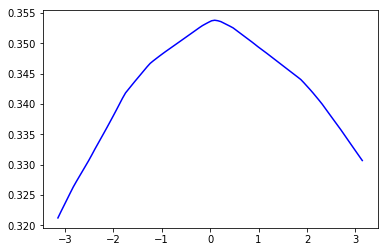

iteration 1200, loss 2.644
iteration 1400, loss 6.956
iteration 1600, loss 3.180
iteration 1800, loss -4.001
iteration 2000, loss 0.619
Epoch: 1, Avg_loss: 2.1067516153678296


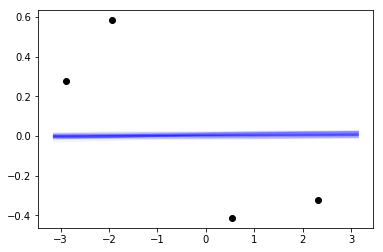

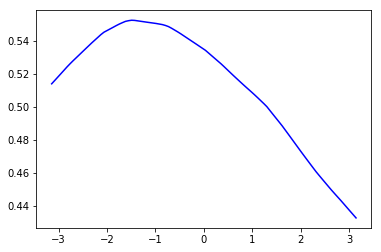

iteration 2200, loss 3.545
iteration 2400, loss -1.988
iteration 2600, loss 3.674
iteration 2800, loss -0.386
iteration 3000, loss 1.529
Epoch: 2, Avg_loss: 1.9010535412840546


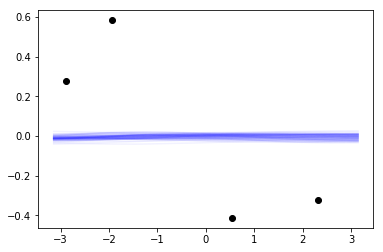

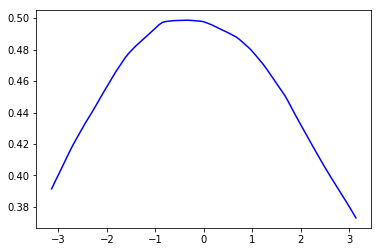

iteration 3200, loss 4.803
iteration 3400, loss -3.661
iteration 3600, loss 7.308
iteration 3800, loss 4.334
iteration 4000, loss 1.920
Epoch: 3, Avg_loss: 1.827219744235277


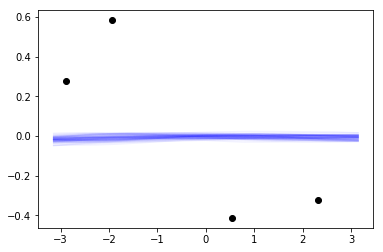

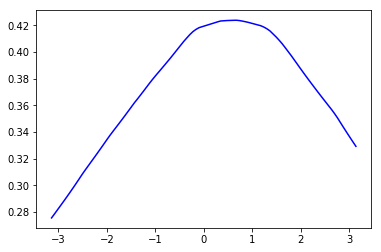

iteration 4200, loss 3.372
iteration 4400, loss 0.501
iteration 4600, loss -3.269
iteration 4800, loss 4.581
iteration 5000, loss -0.579
Epoch: 4, Avg_loss: 1.7566484533436597


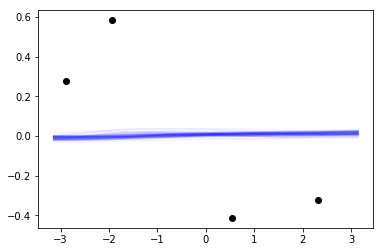

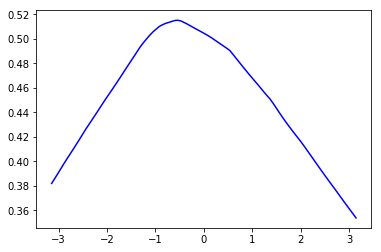

iteration 5200, loss 7.258
iteration 5400, loss 0.619
iteration 5600, loss 1.703
iteration 5800, loss 9.009
iteration 6000, loss 2.188
Epoch: 5, Avg_loss: 1.699831758376211


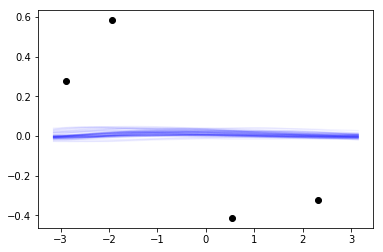

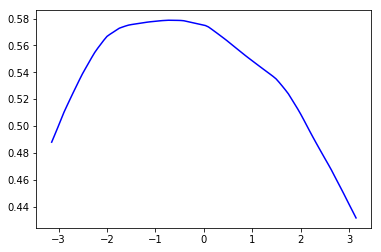

iteration 6200, loss 4.084
iteration 6400, loss -4.137
iteration 6600, loss 2.011
iteration 6800, loss 4.811
iteration 7000, loss 2.658
Epoch: 6, Avg_loss: 1.7784457585560158


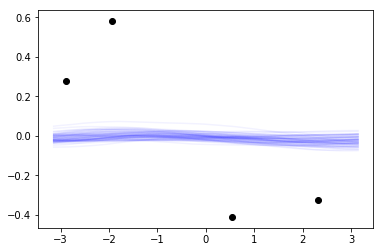

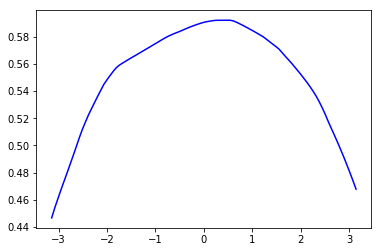

iteration 7200, loss 5.175
iteration 7400, loss -0.482
iteration 7600, loss 4.559
iteration 7800, loss 3.559
iteration 8000, loss -0.884
Epoch: 7, Avg_loss: 1.7874324086345732


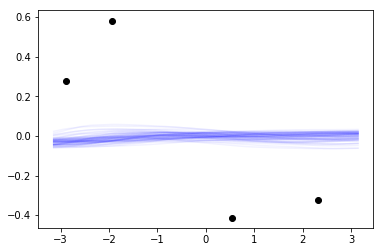

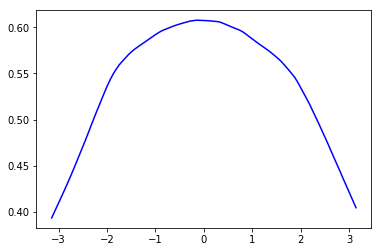

iteration 8200, loss -10.019
iteration 8400, loss 1.722
iteration 8600, loss 4.044
iteration 8800, loss -0.421
iteration 9000, loss 3.945
Epoch: 8, Avg_loss: 1.577888882755302


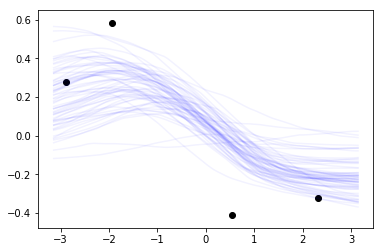

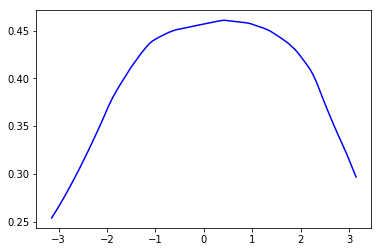

iteration 9200, loss -5.815
iteration 9400, loss -0.545
iteration 9600, loss -7.158
iteration 9800, loss -3.392
iteration 10000, loss 1.764
Epoch: 9, Avg_loss: -1.6778496710062027


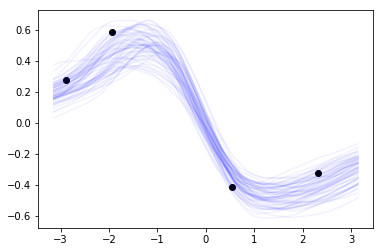

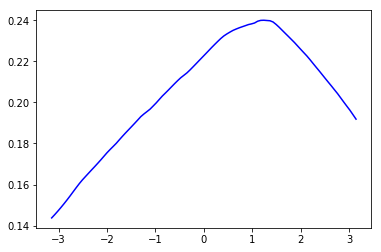

iteration 10200, loss 3.477
iteration 10400, loss -2.033
iteration 10600, loss -5.406
iteration 10800, loss -0.476
iteration 11000, loss -2.485
Epoch: 10, Avg_loss: -3.9260307738184927


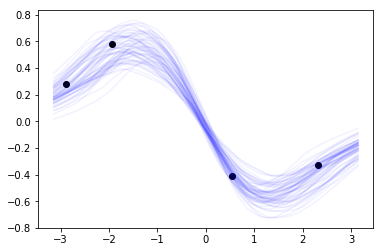

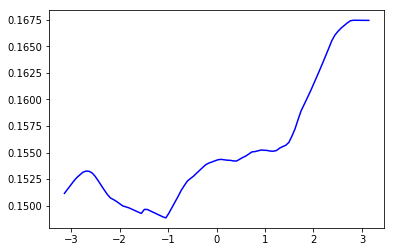

iteration 11200, loss -5.077
iteration 11400, loss -2.221
iteration 11600, loss -2.478
iteration 11800, loss -5.641
iteration 12000, loss -8.325
Epoch: 11, Avg_loss: -4.646484382122755


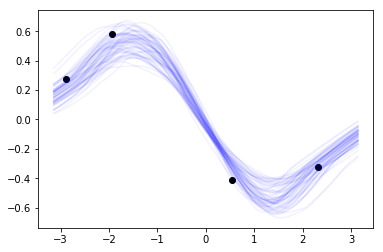

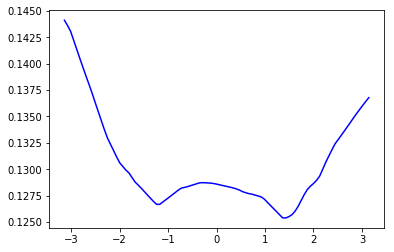

iteration 12200, loss -2.890
iteration 12400, loss -7.490
iteration 12600, loss -9.046
iteration 12800, loss -7.108
iteration 13000, loss -4.826
Epoch: 12, Avg_loss: -4.978368083857


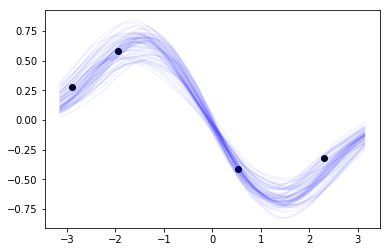

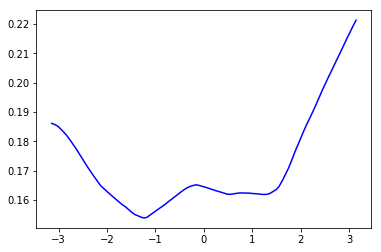

KeyboardInterrupt: 

In [5]:
from torch.utils.data import DataLoader
from training import NeuralProcessTrainer

from utils import context_target_split
batch_size = 2
num_context = 4
num_target = 4


data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Extract a batch from data_loader
for batch in data_loader:
    break




# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)


alpha = 1
neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=200, alpha=alpha)



neuralprocess.training = True
np_trainer.train(data_loader, 30, x_context, y_context)

### Visualize samples from trained prior

The prior should now encode some information about the shapes of the functions.

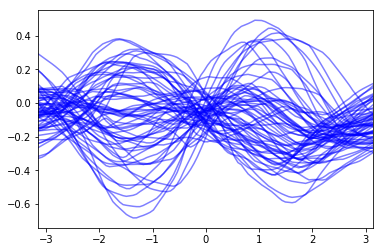

In [6]:
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Visualize samples from posterior

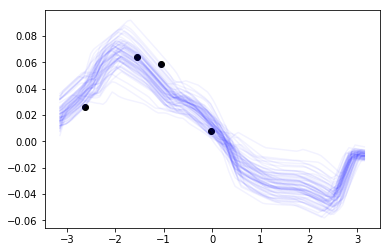

In [38]:
from utils import context_target_split

# Extract a batch from data_loader
for batch in data_loader:
    break

# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

neuralprocess.training = False

for i in range(64):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha=0.05, c='b')

plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')